# Project Apex Legends sensitivy

### Purpose: To perform summary statistics on Apex Legends players' mouse sensitivity and see the relationship with other factors such as main legends

#### Import the required packages

In [1]:
# import packages
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import datetime
from dateutil.relativedelta import relativedelta
import ast
import matplotlib.pyplot as plt
import seaborn as sns

#### Getting the main mouse sensitivity table

In [ ]:
# Specify url
url = 'https://liquipedia.net/apexlegends/List_of_player_mouse_settings/001-400'

# Package the request, send the request and catch the response: r
r = requests.get(url)

# Extracts the response as html: html_doc
html_doc = r.text

# Create a BeautifulSoup object from the HTML: soup
soup = BeautifulSoup(html_doc)

# Get the main table of the page
table = soup.find_all('table')

# Put in DataFrame having player alias as index
df_sens = pd.read_html(str(table), index_col='Player')[0]

# Only get the columns of interest
df_sens = df_sens[['eDPI', 'DPI', 'Sensitivity', 'Polling Rate', 'Mouse']]
# df_sens = df_sens[:5] # Experiment by selecting just some parts of the data

# Check the DataFrame
display(df_sens)

#### Iterating over Player column to get more information in each player's page

In [ ]:
print('Player being processed:')

# Iterate over each player to get more information
for name in df_sens.index:
    print(name) # Print alias of the player being processed
    
    # Create the url and do the same process as getting the main sensitivity table
    sub_url = 'https://liquipedia.net/apexlegends/' + name
    sub_r = requests.get(sub_url)
    sub_html_doc = sub_r.text
    sub_soup = BeautifulSoup(sub_html_doc)
    
    # Information of interest is tagged as div, class = inforbox-cell-2
    result = sub_soup.find_all("div", {"class":"infobox-cell-2"})
    legend_result = sub_soup.find_all("img", {"height":"25"})
    
    # Create a list which more information will be added and later converted to dictionary
    base_list = ['Player', name]
    
    # Add more information to the previos list
    for res in result:
        base_list.append(res.text)
    
    # Convert to dictionary
    player_dict = {base_list[i].replace(":", ""): base_list[i+1] for i in range(0, len(base_list), 2)}
    
    # Replace main legends information from the correct source (<img alt="xxx">)
    legend_revised = str([legend['alt'] for legend in legend_result if legend['alt'] != ""]) # Firstly convert to string to avoid error
    player_dict.update({'Main Legends': legend_revised})
    
    # Iterate over key and value pairs in dictionary and added them to the main sensitivty table
    for key, value in player_dict.items():
        df_sens.loc[name, key] = value
    
    # Pause for 10 seconds (2 seconds at least according to liquipedia's rule) before performing next loop
    time.sleep(10)

# Only get the columns of interest
df_sens = df_sens[['eDPI', 'DPI', 'Sensitivity', 'Polling Rate', 'Mouse', 'Name', 'Romanized Name', 'Birth', 'Country', 'Status', 'Approx. Total Earnings', 'ALGS points (2020-21)', 'Input', 'Main Legends']]    

# Check the DataFrame
display(df_sens)

# Export to .xlsx file
df_sens.to_excel('df_sens.xlsx', sheet_name = 'table_raw')

#### Cleaning data

In [2]:
# Import xlsx file to pandas DataFrame
df_sens_clean = pd.read_excel('df_sens.xlsx')

# Copy those name which was romanized name in the first place to romanized name column
df_sens_clean.loc[df_sens_clean['Romanized Name'].isnull(), 'Romanized Name'] = df_sens_clean['Name']

# Fix birthdate to a proper date time format
df_sens_clean['Birth'] = pd.to_datetime(df_sens_clean['Birth'].str[2:12], errors = 'coerce')

# Create the age column based on difference between today and birthdate
now = pd.Timestamp('now')
df_sens_clean['Age'] = ((now - df_sens_clean['Birth'].dropna()) / pd.Timedelta('365.25 days')).round(0)

# Delete unwanted strings
df_sens_clean['Status'] = df_sens_clean['Status'].str.replace("\n", "")
df_sens_clean['Input'] = df_sens_clean['Input'].str.replace("\n", "")
df_sens_clean['Polling Rate'] = df_sens_clean['Polling Rate'].str.replace("Hz", "")
df_sens_clean['Approx. Total Earnings'] = df_sens_clean['Approx. Total Earnings'].str.replace("$", "").str.replace(",", "")
df_sens_clean['ALGS points (2020-21)'] = df_sens_clean['ALGS points (2020-21)'].str.replace(",", "")

# To get only the first option of sensitivity in case a player has multiple sensitivities
# This is done by delete everything after delimiters including " " and ","
df_sens_clean['Sensitivity'] = df_sens_clean['Sensitivity'].str.replace(" ", ",").str.split(",", 1).str[0]

# Assign a proper type for each column
df_sens_clean['Sensitivity'] = df_sens_clean['Sensitivity'].astype(float)
df_sens_clean['Polling Rate'] = df_sens_clean['Polling Rate'].astype(float)
df_sens_clean['Approx. Total Earnings'] = df_sens_clean['Approx. Total Earnings'].astype(float)
df_sens_clean['ALGS points (2020-21)'] = df_sens_clean['ALGS points (2020-21)'].fillna(0).astype(int)
df_sens_clean['Main Legends'] = df_sens_clean['Main Legends'].apply(ast.literal_eval) # Revert back to list type

# There were some errors of legend name which captured player's team by mistake
# Create a list of available legends and only get the result from intersections of two sets
available_legends = ['Ash', 'Bangalore', 'Bloodhound', 'Caustic', 'Crypto', 'Fuse', 'Gibraltar', 'Horizon', 'Lifeline', 'Loba', 'Mad Maggie', 'Mirage', 'Octane', 'Pathfinder', 'Rampart', 'Revenant', 'Seer', 'Valkyrie', 'Wattson', 'Wraith']
df_sens_clean['Main Legends'] = df_sens_clean['Main Legends'].apply(lambda x: list(set(x) & set(available_legends)))

# Manually calculated eDPI
df_sens_clean['eDPI_manual'] = df_sens_clean['DPI'] * df_sens_clean['Sensitivity']

# Check the DataFrame
display(df_sens_clean)

# Check the type of each column
print(df_sens_clean.dtypes)

# Export the cleaned table to the existing excel file as a new sheet
with pd.ExcelWriter('df_sens.xlsx', engine = 'openpyxl', mode = 'a') as writer:
    df_sens_clean.to_excel(writer, sheet_name = 'table_cleaned')

<ipython-input-2-aa4405a3029a>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_sens_clean['Approx. Total Earnings'] = df_sens_clean['Approx. Total Earnings'].str.replace("$", "").str.replace(",", "")


,Player,eDPI,DPI,Sensitivity,Polling Rate,Mouse,Name,Romanized Name,Birth,Country,Status,Approx. Total Earnings,ALGS points (2020-21),Input,Main Legends,Age,eDPI_manual
0,1tappy,NaN,400.0,2.50,NaN,Kone Pure,NaN,NaN,2000-10-01,Japan,Active,23140.0,3125,Mouse & Keyboard,[Wraith],21.0,1000.0
1,3Mz,NaN,800.0,1.00,NaN,Kone Pure,王虎,Hu Wang,1998-11-15,China,Active,43066.0,12335,Mouse & Keyboard,"[Wraith, Gibraltar]",23.0,800.0
2,7ozzzus,NaN,800.0,1.30,1000.0,G pro superlight,Владимир Воротилов,Vladimir Vorotilov,2003-08-06,Russia,Active,5532.0,3470,Mouse & Keyboard,[Wraith],19.0,1040.0
3,9impulse,NaN,800.0,1.60,1000.0,G PRO X SUPERLIGHT,Кирилл Костив,Kirill Kostiv,1999-10-31,Belarus,Active,107317.0,5460,Mouse & Keyboard,"[Caustic, Gibraltar]",22.0,1280.0
4,Aeon,NaN,400.0,NaN,1000.0,G PRO Wireless,Ramzi Geysen,Ramzi Geysen,1993-05-12,Belgium,Retired,155.0,0,Mouse & Keyboard,[],29.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,vsnz,NaN,800.0,2.00,1000.0,G903,Sean Garcia,Sean Garcia,NaT,United States,Active,21439.0,0,Mouse & Keyboard,[],NaN,1600.0
303,wSerious,NaN,3000.0,1.00,1000.0,Rival 300,Romain Dittmann,Romain Dittmann,1997-08-17,France,Active,20223.0,3710,Mouse & Keyboard,"[Pathfinder, Lifeline]",25.0,3000.0
304,xaniya,NaN,800.0,1.20,1000.0,G Pro SuperLight,Антон Шкуратов,Anton Shkuratov,1999-07-29,Russia,Active,25830.0,6860,Mouse & Keyboard,"[Valkyrie, Wraith]",23.0,960.0
305,xeriffer,NaN,1600.0,0.65,1000.0,XM1R,Franco Samuel Korompai,Franco Samuel Korompai,2001-08-10,Slovakia,Active,2566.0,3120,Mouse & Keyboard,"[Wraith, Pathfinder]",21.0,1040.0


Player                            object
eDPI                             float64
DPI                              float64
Sensitivity                      float64
Polling Rate                     float64
Mouse                             object
Name                              object
Romanized Name                    object
Birth                     datetime64[ns]
Country                           object
Status                            object
Approx. Total Earnings           float64
ALGS points (2020-21)              int32
Input                             object
Main Legends                      object
Age                              float64
eDPI_manual                      float64
dtype: object


#### General information about Apex pro players

In [3]:
# Get the basic information of dataframe
print(df_sens_clean.info())

# Get the summary statistics
display(df_sens_clean.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Player                  307 non-null    object        
 1   eDPI                    42 non-null     float64       
 2   DPI                     301 non-null    float64       
 3   Sensitivity             293 non-null    float64       
 4   Polling Rate            240 non-null    float64       
 5   Mouse                   307 non-null    object        
 6   Name                    285 non-null    object        
 7   Romanized Name          289 non-null    object        
 8   Birth                   268 non-null    datetime64[ns]
 9   Country                 304 non-null    object        
 10  Status                  304 non-null    object        
 11  Approx. Total Earnings  275 non-null    float64       
 12  ALGS points (2020-21)   307 non-null    int32     

,eDPI,DPI,Sensitivity,Polling Rate,Approx. Total Earnings,ALGS points (2020-21),Age,eDPI_manual
count,42.000000,301.000000,293.000000,240.000000,275.000000,307.000000,268.000000,293.000000
mean,1276.554762,792.425249,1.852379,959.904167,18082.778182,3965.179153,24.145522,1254.944710
std,765.634036,718.939333,0.774464,140.588821,31428.275308,4106.331539,3.333703,540.895541
min,360.000000,400.000000,0.200000,100.000000,5.000000,0.000000,17.000000,400.000000
25%,800.000000,400.000000,1.300000,1000.000000,1103.000000,370.000000,22.000000,960.000000
50%,1100.000000,800.000000,1.600000,1000.000000,4556.000000,2590.000000,24.000000,1120.000000
75%,1420.000000,800.000000,2.300000,1000.000000,21061.000000,6785.000000,26.000000,1360.000000
max,4800.000000,10000.000000,6.000000,1000.000000,233350.000000,14455.000000,36.000000,4800.000000


#### Distribution of Apex pro players eDPI

count      293.0
mean     1,254.9
std        540.9
min        400.0
25%        960.0
50%      1,120.0
75%      1,360.0
max      4,800.0
Name: eDPI_manual, dtype: object


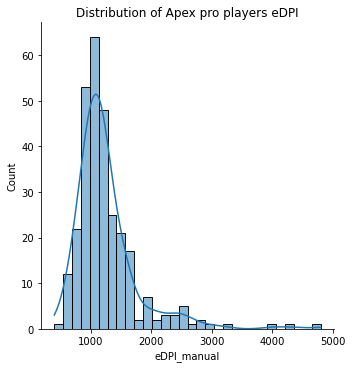

<Figure size 432x288 with 0 Axes>

In [11]:
# Print summary statistics
print(df_sens_clean['eDPI_manual'].describe().apply('{:,.1f}'.format))

# Use seaborn to create distribution plot of eDPI
sns.displot(data = df_sens_clean, x = 'eDPI_manual', kde = True, bins = 30)
plt.title("Distribution of Apex pro players eDPI")
plt.show()
plt.clf()

          count     mean    std      min      25%      50%      75%      max
Status                                                                      
Active    198.0  1,249.3  485.7    585.0    960.0  1,120.0  1,360.0  4,320.0
Inactive    2.0  1,320.0  169.7  1,200.0  1,260.0  1,320.0  1,380.0  1,440.0
Retired    91.0  1,269.7  656.1    400.0    910.0  1,120.0  1,280.0  4,800.0


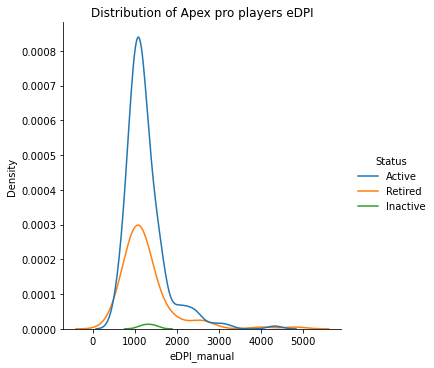

<Figure size 432x288 with 0 Axes>

In [12]:
# Print summary statistics
print(df_sens_clean.groupby('Status')['eDPI_manual'].describe().applymap('{:,.1f}'.format))

# Use seaborn to create distribution plot of eDPI for each status
sns.displot(data = df_sens_clean, x = 'eDPI_manual', kind = 'kde', hue = 'Status')
plt.title("Distribution of Apex pro players eDPI")
plt.show()
plt.clf()

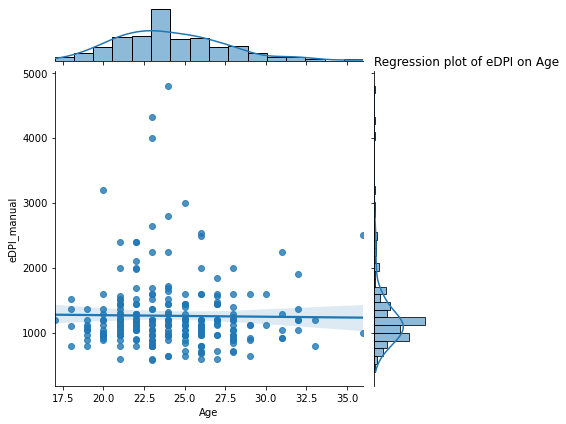

<Figure size 432x288 with 0 Axes>

In [6]:
# Use seaborn to create regression plot of eDPI on age
sns.jointplot(data = df_sens_clean, x = 'Age', y = 'eDPI_manual', kind = 'reg')
plt.title("Regression plot of eDPI on Age", loc = 'left')
plt.show()
plt.clf()

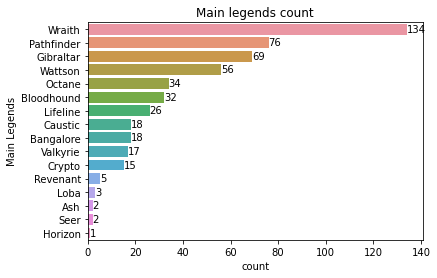

<Figure size 432x288 with 0 Axes>

In [7]:
# Explode the Main Legends column (for those players who have more than one main legends)
df_sens_explode = df_sens_clean.explode('Main Legends')

# Use seaborn to create count plot of main legends used by players
ax = sns.countplot(data = df_sens_explode, y = 'Main Legends', order = df_sens_explode['Main Legends'].value_counts().index)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_width()), (p.get_width(), p.get_y()+0.6))
plt.title("Main legends count")
plt.show()
plt.clf()

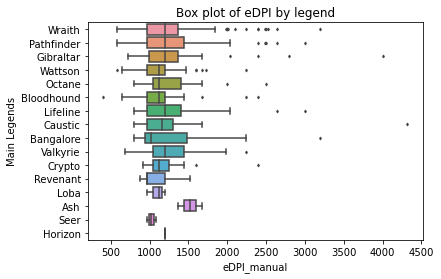

<Figure size 432x288 with 0 Axes>

In [8]:
# Use seaborn to create box plot of eDPI by legend
sns.boxplot(data = df_sens_explode, x = 'eDPI_manual', y = 'Main Legends', order = df_sens_explode['Main Legends'].value_counts().index, fliersize = 2)
plt.title("Box plot of eDPI by legend")
plt.show()
plt.clf()

              count     mean    std    min    25%      50%      75%      max
Legend Type                                                                 
Movement      252.0  1,264.7  441.6  585.0  990.0  1,200.0  1,440.0  3,200.0
Non-movement  263.0  1,244.6  536.9  400.0  960.0  1,120.0  1,300.0  4,800.0


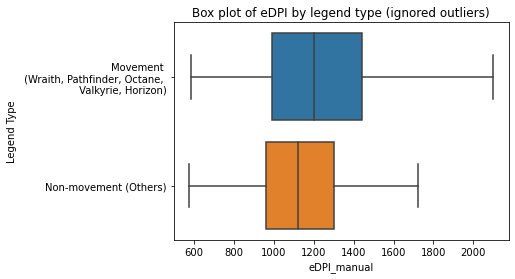

<Figure size 432x288 with 0 Axes>

In [10]:
# Assign legend type as a new column of the dataframe
df_sens_explode['Legend Type'] = ["Movement" if i in ['Wraith', 'Pathfinder', 'Octane', 'Valkyrie', 'Horizon'] else "Non-movement" for i in df_sens_explode['Main Legends']]

# Print summary statistics
print(df_sens_explode.groupby('Legend Type')['eDPI_manual'].describe().applymap('{:,.1f}'.format))

# Use seaborn to create box plot of eDPI by legend type
ax = sns.boxplot(data = df_sens_explode, x = 'eDPI_manual', y = 'Legend Type', showfliers = False)
plt.title("Box plot of eDPI by legend type (ignored outliers)")
ax.set_yticklabels(('Movement \n (Wraith, Pathfinder, Octane, \n Valkyrie, Horizon)', 'Non-movement (Others)'))
plt.show()
plt.clf()

In [13]:
print(df_sens_clean['eDPI_manual'].mode())

0    1200.0
dtype: float64
